# HDBSCAN
Evaluate HDBSCAN as a non-parametric clustering algorithm

## References
[How HDBSCAN Works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

[Grok Chat](https://grok.com/share/bGVnYWN5_cdb89d47-1ebf-4821-9f2f-d7d1563010e6)

In [50]:
import numpy as np
from scipy.spatial.distance import euclidean
import seaborn as sns
import hdbscan
%matplotlib inline

## Ingest
Predict labels and encodings for training and test sets for a SIMS model

In [10]:
!cd .. && python scripts/cluster.py predict  \
    public/models/allen-celltypes+human-cortex+various-cortical-areas.onnx \
    checkpoints/allen-celltypes+human-cortex+various-cortical-areas.h5ad

Generating predictions and encodings for checkpoints/allen-celltypes+human-cortex+various-cortical-areas.h5ad using model public/models/allen-celltypes+human-cortex+various-cortical-areas.onnx
2162 genes in the sample and not in the model
Processing 49494 cells with batch size 32
100%|████████████████████████████████████| 49494/49494 [02:24<00:00, 343.42it/s]
Saved encodings to checkpoints/allen-celltypes+human-cortex+various-cortical-areas-encodings.npy
Saved predictions to checkpoints/allen-celltypes+human-cortex+various-cortical-areas-predictions.npy


In [11]:
!cd .. && python scripts/cluster.py predict  \
    public/models/allen-celltypes+human-cortex+various-cortical-areas.onnx \
    data/allen-celltypes+human-cortex+m1.h5ad

Generating predictions and encodings for data/allen-celltypes+human-cortex+m1.h5ad using model public/models/allen-celltypes+human-cortex+various-cortical-areas.onnx
2162 genes in the sample and not in the model
Processing 76533 cells with batch size 32
100%|████████████████████████████████████| 76533/76533 [03:46<00:00, 337.89it/s]
Saved encodings to data/allen-celltypes+human-cortex+m1-encodings.npy
Saved predictions to data/allen-celltypes+human-cortex+m1-predictions.npy


In [12]:
X_train = np.load("../checkpoints/allen-celltypes+human-cortex+various-cortical-areas-encodings.npy")
Y_train = np.load("../checkpoints/allen-celltypes+human-cortex+various-cortical-areas-predictions.npy")

X_test = np.load("../data/allen-celltypes+human-cortex+m1-encodings.npy")
Y_test = np.load("../data/allen-celltypes+human-cortex+m1-predictions.npy")

with open("../public/models/allen-celltypes+human-cortex+various-cortical-areas.classes", "r") as f:
    labels = [line.strip() for line in f]

print(f"Loaded {X_train.shape[0]} training and {X_test.shape[0]} test samples")

Loaded 49494 training and 76533 test samples


## Train
Calculate clusters and centroids

In [42]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=250
    # min_cluster_size=X_train.shape[0] // 10,
    # min_samples=X_train.shape[0] // 10
)
clusterer.fit(X_train)

# Get cluster labels
labels = clusterer.labels_

# Find unique clusters (excluding noise, which is labeled -1)
unique_clusters = np.unique(labels[labels >= 0])
print(f"{len(unique_clusters)} unique clusters found")

/Users/rcurrie/cell-space/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rcurrie/cell-space/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13 unique clusters found


In [45]:
# Compute centroids and cluster radii
centroids = []
cluster_radii = []
for cluster in unique_clusters:
    cluster_points = X_train[labels == cluster]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)
    # Compute the maximum distance from centroid to any point in the cluster
    distances = [euclidean(centroid, point) for point in cluster_points]
    radius = np.max(distances)  # Define cluster "size" as max distance
    cluster_radii.append(radius)

centroids = np.array(centroids)
print("Cluster Radii:", cluster_radii)

Cluster Radii: [2.0639419555664062, 1.6960346698760986, 2.3505642414093018, 3.320141315460205, 0.33259186148643494, 0.7465940713882446, 0.22006694972515106, 0.2329031080007553, 1.4464304447174072, 0.019144821912050247, 0.038023754954338074, 0.039359766989946365, 0.014480484649538994]


# Visualize

/Users/rcurrie/cell-space/venv/lib/python3.10/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<Axes: ylabel='$\\lambda$ value'>

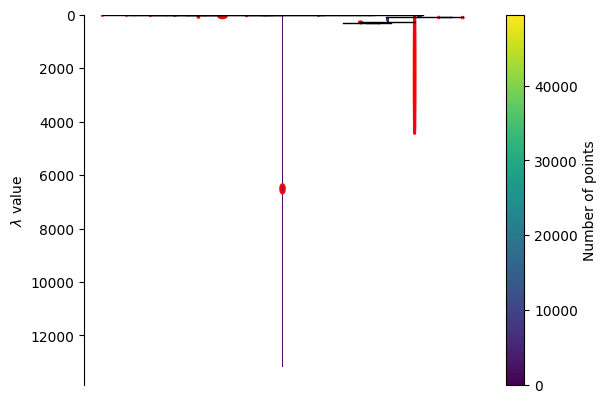

In [51]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))